In [92]:
from model.GloveEmbedding import load_glove_embeddings
%load_ext autoreload
%autoreload 2
import pandas
from pathlib import Path
import os
print(os.getcwd())
TRAIN_DATA_PATH = str(Path("dataset") / "captions_train.txt")
TEST_DATA_PATH = "dataset/captions_test.txt"

train_df = pandas.read_csv(TRAIN_DATA_PATH)
word_counts = {}  # a dict : { word : number of appearances}
max_length = 0
for text in train_df['caption']:
  words = text.split()
  max_length = len(words) if (max_length < len(words)) else max_length
  for w in words:
    try:
      word_counts[w] +=1
    except:
        word_counts[w] = 1


# Chỉ lấy các từ xuất hiện trên 10 lần
word_count_threshold = 5
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold] + ["<PAD>", "<UNK>"]


i2w = {}
w2i = {}

id = 0
for w in vocab:
    w2i[w] = id
    i2w[id] = w
    id += 1





import torch
from torch import nn

from data.CustomDataset import CustomDataset

from model.ImageCaptioningModel_transformer import ImageCaptionModel
import matplotlib.pyplot as plt



EMBED_DIM = 200   # Kích thước vector nhúng
NUM_HEADS = 4    # Số head trong multi-head attention
UNITS = 256
IMAGE_SIZE = 224

VOCAB_SIZE = len(vocab)
MAX_SEQ_LEN = max_length
BATCH_SIZE = 512


learning_rate = 0.001
epochs = 50
patience = 10
min_delta = 0.001
glove_tensor = load_glove_embeddings("model/glove.6B/glove.6B.200d.txt", w2i, embedding_dim=EMBED_DIM)

# Khởi tạo mô hình
model = ImageCaptionModel(
    w2i,
    glove_tensor,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    units=UNITS,
    vocab_size=VOCAB_SIZE,
    max_len=MAX_SEQ_LEN
)
model.load_state_dict(torch.load("best_model_flick_v2.pth"))


test_dataset = CustomDataset(
    TEST_DATA_PATH,
    w2i,
    max_length)

train_dataset = CustomDataset(
    TRAIN_DATA_PATH,
    w2i,
    max_length)




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
criterion = nn.CrossEntropyLoss(ignore_index=w2i["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)






The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
C:\Users\NguyenPC\Desktop\python_prj
Loaded 8095 images and 8095 captions.
Loaded 32360 images and 32360 captions.
cuda


In [73]:

def generate_caption(model, image, w2i, i2w, max_len=50, device="cpu"):
    model.eval()
    with torch.no_grad():
        image = image.to(device).unsqueeze(0)  # (1, 3, 224, 224)
        features = model.cnn_model(image)
        encoder_output = model.encoder(features)

        input_ids = [w2i["<START>"]]

        for _ in range(max_len):
            input_tensor = torch.tensor([input_ids], device=device)

            # Tạo mask (True = token thật, False = <PAD>)
            mask = (input_tensor != w2i["<PAD>"])

            output = model.decoder(input_tensor, encoder_output, mask=mask)

            next_token_logits = output[0, -1, :]  # Lấy token cuối cùng
            next_token = torch.argmax(next_token_logits).item()

            if next_token == w2i["<END>"]:
                break

            input_ids.append(next_token)

        caption = [i2w[idx] for idx in input_ids[1:]]  # Bỏ <START>
        return " ".join(caption)
import matplotlib.pyplot as plt
def test():
    index = torch.randint(1, len(test_dataset), (1,)).item()

    image, image_transformed, _ = test_dataset[index]



    caption = generate_caption(model, image_transformed, w2i, i2w, max_len=30)

    # Chuyển tensor ảnh về PIL Image để hiển thị

    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    print("".join(caption))


a football player in a red uniform is being tackled in the background


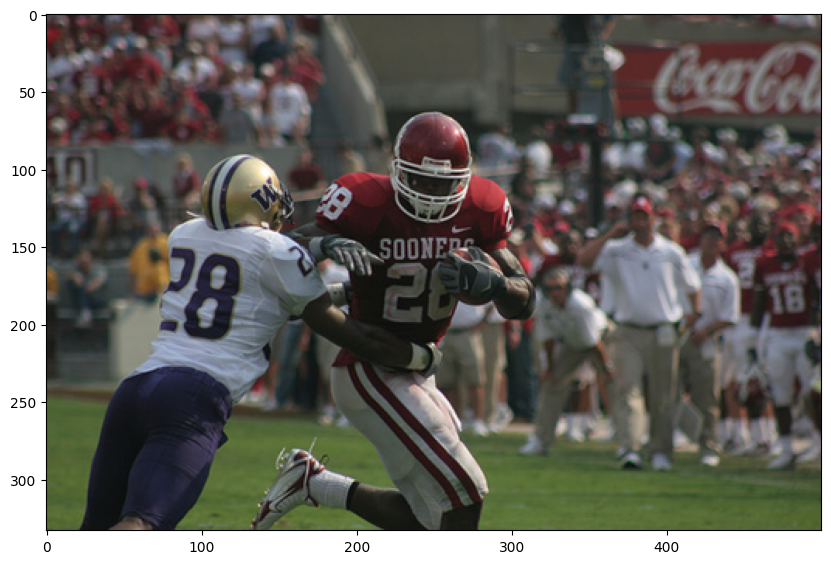

In [89]:
test()


(process:8988): Pango-WARNING **: 22:42:28.027: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:20436): Pango-WARNING **: 22:42:28.461: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.

(process:20172): Pango-WARNING **: 22:42:28.600: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


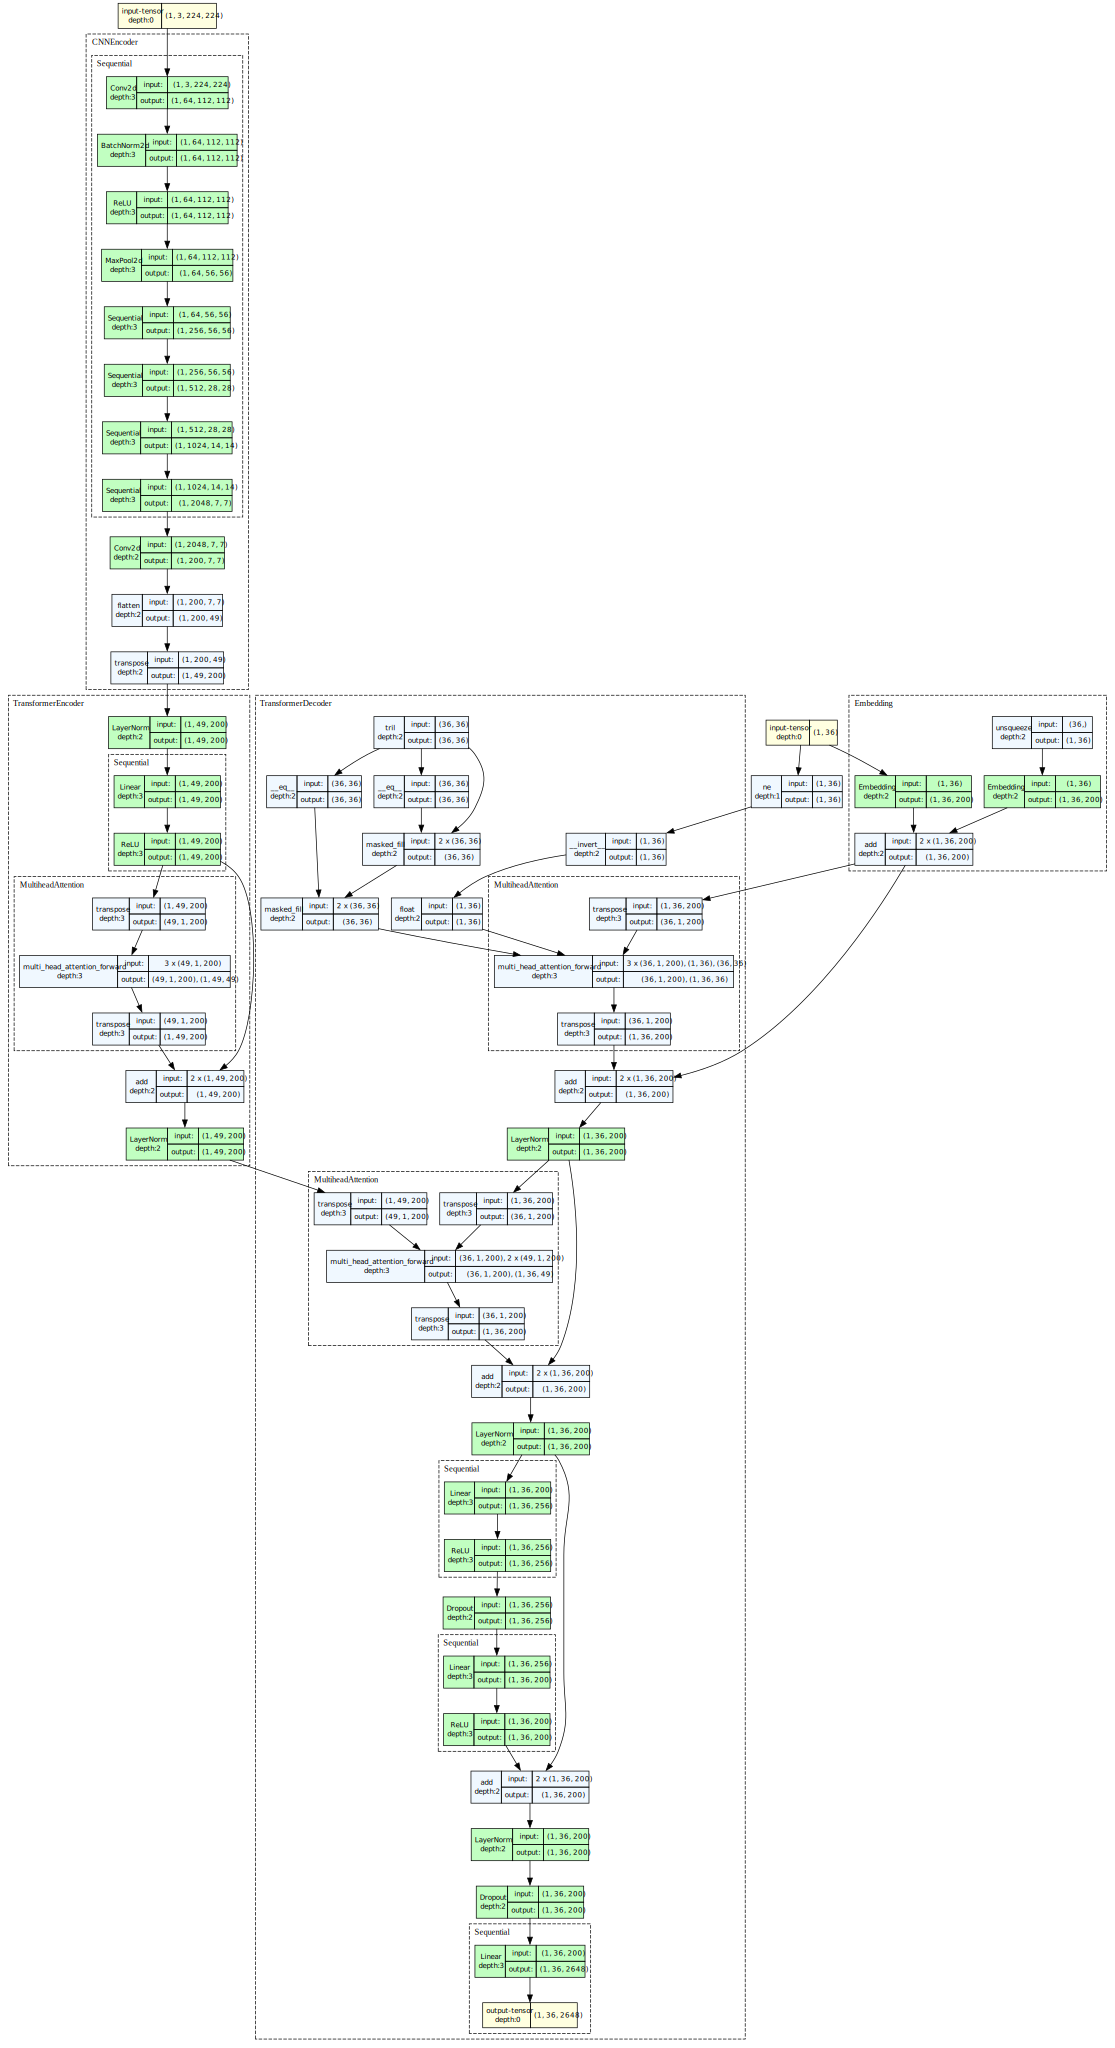

In [93]:
from torchview import draw_graph

index = torch.randint(1, len(train_dataset), (1,)).item()

image, image_transformed, caption = train_dataset[index]
image_transformed = image_transformed.unsqueeze(0)  # (1, 3, H, W)
caption = caption.unsqueeze(0)                      # (1, seq_len)

# Truyền input dưới dạng tuple
graph = draw_graph(
    model,
    input_data=(image_transformed, caption[:, :-1]),  # caption input for decoder
    expand_nested=True,
    show_shapes=True,
    save_graph=True,
    graph_name="caption_model_graph",

)

graph.visual_graph.render(
    filename="caption_model_graph",  # tên file đầu ra
    format="jpg",                    # định dạng: jpg
    directory=".",                   # thư mục lưu file
    cleanup=True                     # xóa file trung gian .dot
)
graph.visual_graph


In [12]:
from torchviz import make_dot



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Đưa model và dữ liệu lên đúng device
model = model.to(device)
image_transformed = image_transformed.to(device)
caption = caption.to(device)

# Forward pass
y = model(image_transformed, caption)

# Vẽ graph (vẫn dùng CPU nên không sao)
make_dot(y, params=dict(model.named_parameters())).render("model_architech", format="png")


'model_architech.png'

In [15]:
import hiddenlayer as hl
import torch.nn as nn

class WrappedModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, *inputs):  # Nhận 2 input riêng
        image, caption = inputs
        return self.model(image, caption)

# Đảm bảo input và model trên cùng thiết bị (CPU tốt hơn khi visualize)
model = model.cpu()
image_transformed = image_transformed.cpu()
caption = caption.cpu()

# Bọc model rồi vẽ
wrapped = WrappedModel(model)
graph = hl.build_graph(wrapped, (image_transformed, caption[:, :-1]))  # caption phải trim BOS/EOS nếu dùng như vậy
graph.theme = hl.graph.THEMES["blue"].copy()
graph.save("model_hl", format="png")


C:\Users\NguyenPC\Desktop\python_prj\model\TransformerDecoder.py:72: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert not torch.isnan(attn_weights).any(), "NaN in attention weights"
C:\Users\NguyenPC\Desktop\python_prj\model\TransformerDecoder.py:73: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert not torch.isnan(attn_output_1).any(), "NaN in attn_output_1"
C:\Users\NguyenPC\Desktop\python_prj\model\TransformerDecoder.py:75: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data f

AttributeError: module 'torch.onnx' has no attribute '_optimize_trace'